# Classification of trapped particles
Using forward scattering information.

In [48]:
import numpy as np
import os
from scipy import *
import pandas as pd
from matplotlib.pyplot import *
from sklearn import *
#* is used to import all from that library 

# Load the time domain data 

In [49]:
def load_data(npoints):
    
    #path to the folder where data is stored
    #to find all the files required 
    folder_path = "D:data OT//"

    #list the paths ending in .TDdat
    #to use only the files .TDdat, for files in that directory that end with .TDdat, where f are the files.TDdat
    path_files_TD = [folder_path+f for f in os.listdir(folder_path) if f.endswith('.dat')]

    #store the info for each file
    target = [] #type of target
    x_data = [] #xdata
    y_data = [] #ydata
    sum_data = [] #intensity data

    #read data
    #for each .dat file
    for i in range(0,len(path_files_TD)):

        #for a given path, all directory for each file will be printed
        current_path = path_files_TD[i]
        
        #read type

        #load data-read csv file
        #skiprows=2 to skip the text in .dat file 
        #delimiter='/t' space between each column 
        current_df = pd.read_csv(current_path,skiprows=2,header=None,delimiter='\t')
        #current_df contains the four columns of the file, which correspond to 
        #[0]-xdata, [1]-ydata, [2]-sum

        #Acquired 150 seconds(2 and half min) which correpond to approx 1500000 points, and so 
        #for 2 min(120 s) we can consider 1200000 points for each file
        xx = np.array(current_df[0])[0:600*npoints]
        yy = np.array(current_df[1])[0:600*npoints]
        sums = np.array(current_df[2])[0:600*npoints]

        #cycle 
        #for each file [for i in range(0,len(path_files_TD))] divide the original file in sections that start in 
        #(i*npoints) and end in (i+1)*npoints), for each i in range(0, int(len(xx)/npoints), that is 59
        #x_data.append([xx[int(i*npoints):int((i+1)*npoints)] for i in range(0, int(len(xx)/npoints))])
        #y_data.append([yy[i*npoints:(i+1)*npoints] for i in range(0, int(len(yy)/npoints))])
        #sum_data.append([sums[i*npoints:(i+1)*npoints] for i in range(0, int(len(sums)/npoints))])
        #np.array split (split an array into multiple sub-arrays of equal or near-equal size)
        splits=int(len(xx)/npoints)
        x_data.append(np.array_split(np.array(xx),splits))
        y_data.append(np.array_split(np.array(yy),splits))
        sum_data.append(np.array_split(np.array(sums),splits))


        #print of the number of segments generated, considering the length divided by npoints (20000)
        print(current_path + " Read "+ str(int(len(xx)/npoints)) + " segments", end = '\r')

        #each file will be divided in 59 segments, which will be appended as targets     
        #read type
        for i in range(0,int(len(xx)/npoints)):
            #it will create 59 files of the same file and then in each one it will save 59 segments of the same original file
            #each part is stored in each 3umPMMA.dat file (59x)
            target.append(current_path.split('//')[1].split('.')[0][:-1])


    return target, x_data, y_data, sum_data


def data_classifier(x_data, y_data, sum_data, target):
    data_to_classify = []
    data_to_classify2 = []
    data_to_classify3 = []
    for i in range(0,len(x_data)):
        for j in range(0,len(x_data[i])):
            data_to_classify.append(np.abs(np.fft.fft(x_data[i][j])))
            data_to_classify2.append(np.abs(np.fft.fft(y_data[i][j])))
            data_to_classify3.append(np.abs(np.fft.fft(sum_data[i][j])))

    data_to_classify=np.array(data_to_classify)
    data_to_classify2=np.array(data_to_classify2)
    data_to_classify3=np.array(data_to_classify3)

    dummy_labels = []
    labels = []
    unique_targets = np.unique(target)
    for i in range(0,len(target)):
        arr = np.zeros(len(unique_targets))
        labels.append(np.where(target[i]==unique_targets)[0][0])
        index = np.where(target[i]==unique_targets)[0][0]
        arr[index] = 1 
        dummy_labels.append(arr)

    labels=np.array(labels)
    dummy_labels = np.array(dummy_labels)
    
    return data_to_classify, data_to_classify2, data_to_classify3, labels, dummy_labels, unique_targets


def pca_data(data_to_classify, data_to_classify2, data_to_classify3, ncomp=3):
    
    model = decomposition.PCA(n_components=ncomp)
    model.fit(data_to_classify)
    PCs1 = model.transform(data_to_classify)

    model.fit(data_to_classify2)
    PCs2 = model.transform(data_to_classify2)

    model.fit(data_to_classify3)
    PCs3 = model.transform(data_to_classify3)
    
    PCs = np.concatenate([PCs1,PCs2,PCs3],axis=1)
    
    return PCs


In [42]:

def test_a_model(model, npoints, confusion_matrix = False):
    target, x_data, y_data, sum_data = load_data(npoints)
    data_to_classify, data_to_classify2, data_to_classify3, labels, dummy_labels, unique_targets = data_classifier(x_data, 
                                                                                                   y_data, sum_data, target)
    PCs = pca_data(data_to_classify, data_to_classify2, data_to_classify3, ncomp=3)
    print('\n')
    print(data_to_classify.shape)
    print(model)
    ts=0.2
    rs=30

    X_train, X_test, y_train, y_test = model_selection.train_test_split(PCs, labels, test_size=ts, random_state=rs)



    nfolds = 30
    
    cv = model_selection.ShuffleSplit(n_splits=nfolds, test_size=ts, random_state=rs)
    scores = model_selection.cross_val_score(model, PCs, labels, cv=cv)
    print("Model Accuracy -> " + str(np.mean(scores)))

    if confusion_matrix:
        #Generate a confusion matrix
        labels_pred = model_selection.cross_val_predict(model, PCs, labels, cv=5)
        conf_mat = metrics.confusion_matrix(labels, labels_pred,normalize="true")
        #subplots()
        metrics.ConfusionMatrixDisplay(conf_mat,display_labels=unique_targets).plot(cmap=cm.Blues)
        yticks(fontsize=6)
        xticks(fontsize=6)
    
    return scores

D:data OT//water6.dat Read 600 segmentsts

(21600, 200)
RidgeClassifier()
Model Accuracy -> 0.7430015432098765


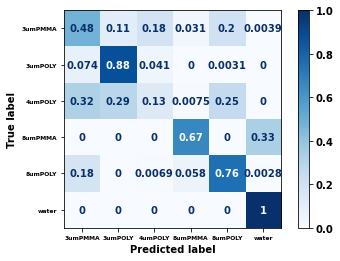

In [45]:
model = ensemble.RandomForestClassifier(n_estimators=1)
#model = linear_model.RidgeClassifier()
npoints = 200
scores = test_a_model(model, npoints, True)

D:data OT//water6.dat Read 600 segmentsts

(21600, 5)
Model Accuracy -> 0.9982947530864196
D:data OT//water6.dat Read 600 segmentsts

(21600, 20)
Model Accuracy -> 0.9957638888888891
D:data OT//water6.dat Read 600 segmentsts

(21600, 100)


KeyboardInterrupt: 

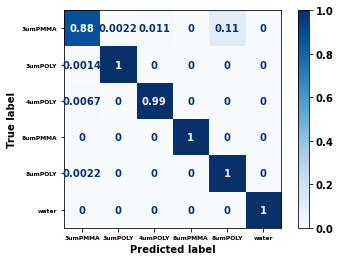

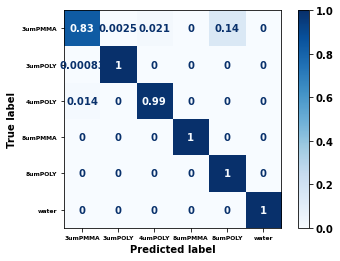

In [39]:
#model = cross_decomposition.PLSRegression().fit(X=data_to_classify,Y=dummy_labels)
#model = discriminant_analysis.LinearDiscriminantAnalysis()
#model = linear_model.LogisticRegression()
#model = svm.SVC()
npoints_list=[5,20,100,200,500,1000,2000]

scores_min =[]
scores_max =[]
scores_mean =[]

model = ensemble.RandomForestClassifier(n_estimators=60)

for npoints in npoints_list:    
    scores = test_a_model(model, npoints, True)
    scores_min.append(min(scores))
    scores_max.append(max(scores))
    scores_mean.append(np.mean(scores))

subplots()
title("Scores for RandomForestClassifier")
plot(npoints_list, scores_mean, ls='--', marker='o', color='k', lw=0.5)
fill_between(npoints_list, scores_min, scores_max,color='grey')


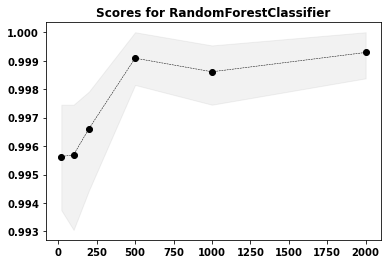

In [36]:
subplots()
title("Scores for RandomForestClassifier")
plot(npoints_list, scores_mean, ls='--', marker='o', color='k', lw=0.5)
fill_between(npoints_list, scores_min, scores_max,color='grey', alpha=0.1)


## Plot acquired data

<IPython.core.display.Javascript object>


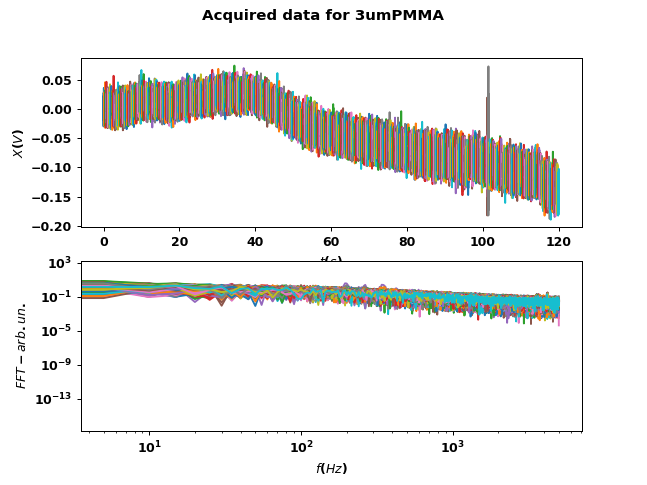

1200000
Total time used for this measurement 0.2 seconds
Total number of files acquired is 600 files
[0.000e+00 1.000e-04 2.000e-04 ... 1.997e-01 1.998e-01 1.999e-01]
2000
2000
0
[ 0.0136  0.008   0.0087 ... -0.0008  0.0001  0.0015]
2000


In [26]:
%matplotlib notebook
#import matplotlib.pyplot as plt

#In suptitle the name is defined by target which varies from 0 to 59 for each type file. And so, index 1 is defined for 
#3umPMMA from 0 to 59, and so, to be adjusted to each file in t_data which varies from t_data[0] to t_data[35], and so 
#it must be divided  by number of slipts, so that from 0 to 59, the int(index1/splits) is related to file 0, 3umPMMA

#index 1 varies from 0 to 2160
index1 = 2
#graph aspect and respective axis labels
figure(figsize=[8,6])
subplot(211)
ax1=gca() #to get the axis
#axis labels
ax1.set_xlabel(r"$t (s)$")
ax1.set_ylabel(r"$X (V)$")
subplot(212)
ax2=gca() #to get the axis
#axis labels
ax2.set_xlabel(r"$f (Hz)$")
ax2.set_ylabel(r"$FFT - arb.un.$")
#log scale 
ax2.set_yscale('log')
ax2.set_xscale('log')
 
#inverse of the sample spacing(seconds) dt

dt=1E-4
total_time=npoints*dt

print(len(xx))

time=np.arange(0,total_time,dt)
#x=np.arange(0,1200000)*dt
#print(x)

splits=int(len(xx)/npoints)
for chunk in range(0, splits):    
    #title name
    #target varies from 0 to 59 for the first file, that is index1=1
    suptitle("Acquired data for " + target[index1])
    
    time_int=npoints*dt*chunk+time
    ax1.plot(time_int,x_data[int(index1/splits)][chunk],label="Split "+str(chunk))
    
    data_to_fft = x_data[index1][chunk]
    fft_data = np.fft.fft(data_to_fft)
    fft_data = np.fft.fftshift(fft_data)
    fft_freq = np.fft.fftfreq(len(fft_data),dt)
    fft_freq = np.fft.fftshift(fft_freq)
    
    plot(fft_freq,abs(fft_data) ,label="Split "+str(chunk))

print("Total time used for this measurement", total_time, "seconds")
print("Total number of files acquired is", (int(len(xx)/npoints)), "files")
print((time))
print(len(x_data[0][0]))
print(len(time_int))
print(int(index1/splits))
print(x_data[0][0])
print(len(x_data[0][0]))

# Classify data
Prepare the data, based on the FFT of each chunk

In [27]:
data_to_classify = []
data_to_classify2 = []
data_to_classify3 = []
for i in range(0,len(x_data)):
    for j in range(0,len(x_data[i])):
        data_to_classify.append(np.abs(np.fft.fft(x_data[i][j])))
        data_to_classify2.append(np.abs(np.fft.fft(y_data[i][j])))
        data_to_classify3.append(np.abs(np.fft.fft(sum_data[i][j])))

data_to_classify=np.array(data_to_classify)
data_to_classify2=np.array(data_to_classify2)
data_to_classify3=np.array(data_to_classify3)

dummy_labels = []
labels = []
unique_targets = np.unique(target)
for i in range(0,len(target)):
    arr = np.zeros(len(unique_targets))
    labels.append(np.where(target[i]==unique_targets)[0][0])
    index = np.where(target[i]==unique_targets)[0][0]
    arr[index] = 1 
    dummy_labels.append(arr)

labels=np.array(labels)
dummy_labels = np.array(dummy_labels)
print(dummy_labels)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


## PCA Analysis
Decompose the data based on principal components, and represent only the Principal component analysis of data_to_classify, corresponding to the x_data

<IPython.core.display.Javascript object>


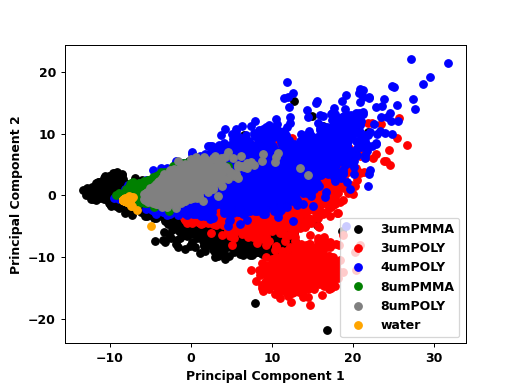

<IPython.core.display.Javascript object>


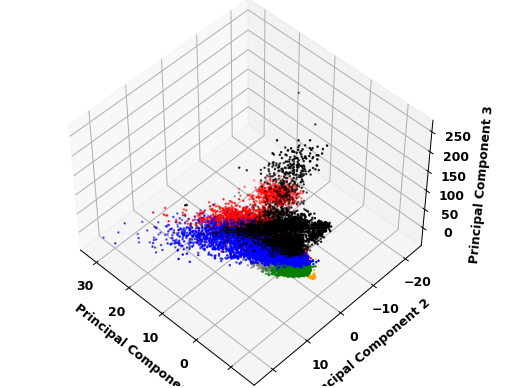

<IPython.core.display.Javascript object>


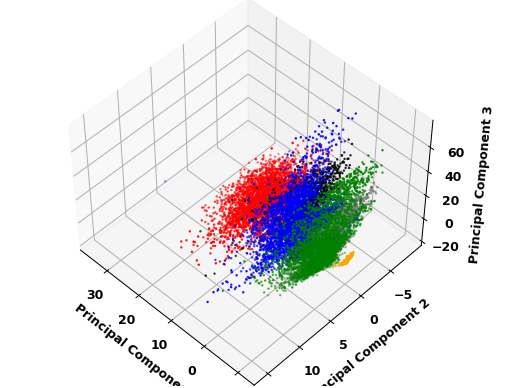

<IPython.core.display.Javascript object>


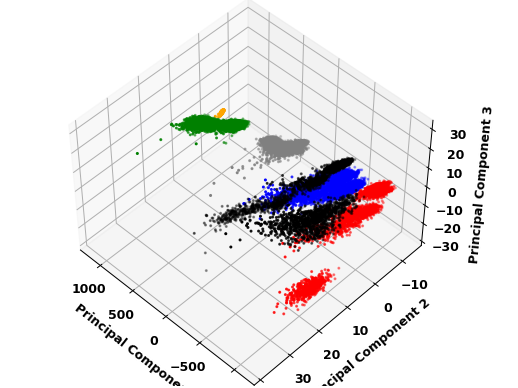

<IPython.core.display.Javascript object>


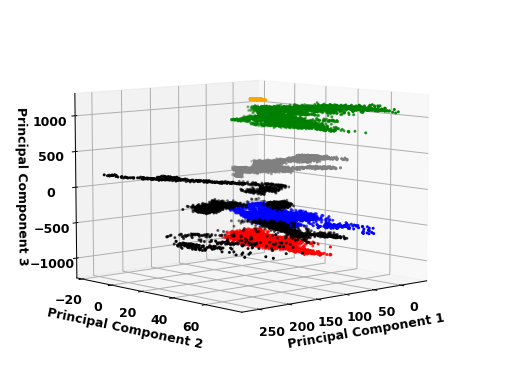

Text(0.5, 0, 'Principal Component 3')

In [48]:
from sklearn import *

ncomp=3

model = decomposition.PCA(n_components=ncomp)
model.fit(data_to_classify)
PCs1 = model.transform(data_to_classify)

model.fit(data_to_classify2)
PCs2 = model.transform(data_to_classify2)

model.fit(data_to_classify3)
PCs3 = model.transform(data_to_classify3)


subplots()
label0=unique_targets[0]
label1=unique_targets[1]
label2=unique_targets[2]
label3=unique_targets[3]
label4=unique_targets[4]
label5=unique_targets[5]

i0= np.where(labels==0)[0]
i1= np.where(labels==1)[0]
i2= np.where(labels==2)[0]
i3= np.where(labels==3)[0]
i4= np.where(labels==4)[0]
i5= np.where(labels==5)[0]

pc1 = 1
pc2 = 2
c=['k','r','b','g','gray','orange']


plot(PCs1[i0,pc1],PCs1[i0,pc2],'o',color=c[0],label=label0)
plot(PCs1[i1,pc1],PCs1[i1,pc2],'o',color=c[1],label=label1)
plot(PCs1[i2,pc1],PCs1[i2,pc2],'o',color=c[2],label=label2)
plot(PCs1[i3,pc1],PCs1[i3,pc2],'o',color=c[3],label=label3)
plot(PCs1[i4,pc1],PCs1[i4,pc2],'o',color=c[4],label=label4)
plot(PCs1[i5,pc1],PCs1[i5,pc2],'o',color=c[5],label=label5)
xlabel("Principal Component 1")
ylabel('Principal Component 2')
legend()

from mpl_toolkits.mplot3d import Axes3D
size=1
e_color=None
pc3=0
fig = figure()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(PCs1[i0,pc1], PCs1[i0,pc2], PCs1[i0,pc3], color=c[0],edgecolor=e_color,s=size)
ax.scatter(PCs1[i1,pc1], PCs1[i1,pc2], PCs1[i1,pc3], color=c[1],edgecolor=e_color,s=size)
ax.scatter(PCs1[i2,pc1], PCs1[i2,pc2], PCs1[i2,pc3], color=c[2],edgecolor=e_color,s=size)
ax.scatter(PCs1[i3,pc1], PCs1[i3,pc2], PCs1[i3,pc3], color=c[3],edgecolor=e_color,s=size)
ax.scatter(PCs1[i4,pc1], PCs1[i4,pc2], PCs1[i4,pc3], color=c[4],edgecolor=e_color,s=size)
ax.scatter(PCs1[i5,pc1], PCs1[i5,pc2], PCs1[i5,pc3], color=c[5],edgecolor=e_color,s=size)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

fig = figure()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(PCs2[i0,pc1], PCs2[i0,pc2], PCs2[i0,pc3], color=c[0],edgecolor=e_color,s=size)
ax.scatter(PCs2[i1,pc1], PCs2[i1,pc2], PCs2[i1,pc3], color=c[1],edgecolor=e_color,s=size)
ax.scatter(PCs2[i2,pc1], PCs2[i2,pc2], PCs2[i2,pc3], color=c[2],edgecolor=e_color,s=size)
ax.scatter(PCs2[i3,pc1], PCs2[i3,pc2], PCs2[i3,pc3], color=c[3],edgecolor=e_color,s=size)
ax.scatter(PCs2[i4,pc1], PCs2[i4,pc2], PCs2[i4,pc3], color=c[4],edgecolor=e_color,s=size)
ax.scatter(PCs2[i5,pc1], PCs2[i5,pc2], PCs2[i5,pc3], color=c[5],edgecolor=e_color,s=size)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

fig = figure()
size=2
e_color=None
pc1 = 0
pc2 = 1
pc3=2
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(PCs3[i0,pc1], PCs3[i0,pc2], PCs3[i0,pc3], color=c[0],edgecolor=e_color,s=size)
ax.scatter(PCs3[i1,pc1], PCs3[i1,pc2], PCs3[i1,pc3], color=c[1],edgecolor=e_color,s=size)
ax.scatter(PCs3[i2,pc1], PCs3[i2,pc2], PCs3[i2,pc3], color=c[2],edgecolor=e_color,s=size)
ax.scatter(PCs3[i3,pc1], PCs3[i3,pc2], PCs3[i3,pc3], color=c[3],edgecolor=e_color,s=size)
ax.scatter(PCs3[i4,pc1], PCs3[i4,pc2], PCs3[i4,pc3], color=c[4],edgecolor=e_color,s=size)
ax.scatter(PCs3[i5,pc1], PCs3[i5,pc2], PCs3[i5,pc3], color=c[5],edgecolor=e_color,s=size)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

fig = figure()
size=2
e_color=None
pc1 = 0
pc2 = 1
pc3=2
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(PCs1[i0,pc1], PCs2[i0,pc1], PCs3[i0,pc1], color=c[0],edgecolor=e_color,s=size)
ax.scatter(PCs1[i1,pc1], PCs2[i1,pc1], PCs3[i1,pc1], color=c[1],edgecolor=e_color,s=size)
ax.scatter(PCs1[i2,pc1], PCs2[i2,pc1], PCs3[i2,pc1], color=c[2],edgecolor=e_color,s=size)
ax.scatter(PCs1[i3,pc1], PCs2[i3,pc1], PCs3[i3,pc1], color=c[3],edgecolor=e_color,s=size)
ax.scatter(PCs1[i4,pc1], PCs2[i4,pc1], PCs3[i4,pc1], color=c[4],edgecolor=e_color,s=size)
ax.scatter(PCs1[i5,pc1], PCs2[i5,pc1], PCs3[i5,pc1], color=c[5],edgecolor=e_color,s=size)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

<IPython.core.display.Javascript object>


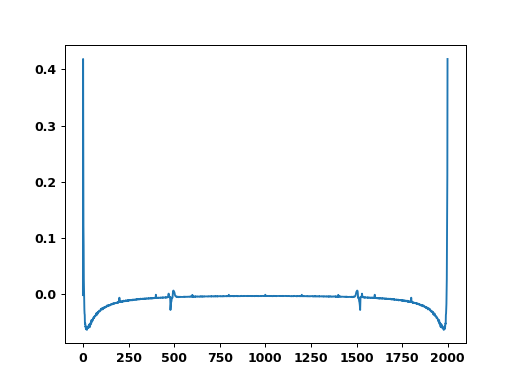

In [38]:
subplots()
plot(model.components_[2])

# Classifier based on PCA

In [29]:
from sklearn import *

ts=0.2
rs=30

X_train, X_test, y_train, y_test = model_selection.train_test_split(PCs, labels, test_size=ts, random_state=rs)

#model = cross_decomposition.PLSRegression().fit(X=data_to_classify,Y=dummy_labels)
#model = discriminant_analysis.LinearDiscriminantAnalysis()
#model = linear_model.LogisticRegression()
#model = svm.SVC()
model = ensemble.RandomForestClassifier(n_estimators=60)
model.fit(X_train,y_train)

print('Score test')
print(model.score(X_test,y_test))

Score test
0.9988425925925926


# Scoring the model

Model Accuracy -> 0.9991820987654321


<IPython.core.display.Javascript object>


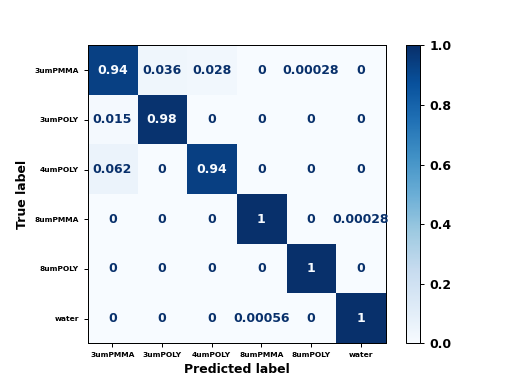

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '3umPMMA'),
  Text(1, 0, '3umPOLY'),
  Text(2, 0, '4umPOLY'),
  Text(3, 0, '8umPMMA'),
  Text(4, 0, '8umPOLY'),
  Text(5, 0, 'water')])

In [30]:
#Crossvalidation score
ts=0.2
rs=0
nfolds=30

cv = model_selection.ShuffleSplit(n_splits=nfolds, test_size=ts, random_state=rs)
scores = model_selection.cross_val_score(model, PCs, labels, cv=cv)
print("Model Accuracy -> " + str(np.mean(scores)))

#Generate a confusion matrix
labels_pred = model_selection.cross_val_predict(model, PCs, labels, cv=5)
conf_mat = metrics.confusion_matrix(labels, labels_pred,normalize="true")
metrics.ConfusionMatrixDisplay(conf_mat,display_labels=unique_targets).plot(cmap=cm.Blues)
yticks(fontsize=6)
xticks(fontsize=6)